# Lab 3: sport vs politics

Our goal is to build a system that:
1. everyday collects a large set of random tweets and groups them in tweets about politics
2. for each of the two groups, shows the main topics of discussion

Unfortunately, it is very difficult to collect a proper number of tweets from X using its API. To build a reasonable dataset, we rely on existing datasets:
- tweets about 2022 FIFA World Cup (sport tweets)
- tweets about Joe Biden (politics tweets)
We need a third category of tweets, random tweets that do not belong to these two categories. To generate them we will use sentences in some free and well known books.

Please note that we are using biased data that will lead to a biased system: sport is not just football and politics does not include only Joe Biden. Since we are aware of it, we can start this challenge.


## Preparing the data

We will use:
- `pandas` for organizing the data;
- `nltk` and `langdetect` to process text;
- `scikit-learn` to train ML models;
- `wordcloud` for fancy visualization;

In [48]:
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install langdetect
!pip install wordcloud

In [49]:
import pandas as pd
import random, string, nltk, re
from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.book import *
from nltk.tokenize import sent_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('genesis')
nltk.download('inaugural')
nltk.download('nps_chat')
nltk.download('webtext')
nltk.download('treebank')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package inaugural to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package nps_chat to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /home/alessandro/nltk_data...
[nltk_data]   Package treebank is already up

True

We start by loading 5000 tweets from each of csv files.

In [50]:
sports_tweets = pd.read_csv("./tweets_sport/fifa_world_cup_2022_tweets.csv", nrows=5000, usecols=["Tweet"], low_memory=False)
politics_tweets = pd.read_csv("./tweets_politics/hashtag_joebiden.csv", nrows=5000, usecols=["tweet"], low_memory=False)

In [51]:
sports_tweets.columns=["tweet"]
sports_tweets

,tweet
0,What are we drinking today @TucanTribe \n@MadB...
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,Worth reading while watching #WorldCup2022 htt...
3,Golden Maknae shinning bright\n\nhttps://t.co/...
4,"If the BBC cares so much about human rights, h..."
...,...
4995,Looks like the offside controversy isn't going...
4996,Another goal by the same captain lol 🤣😂😂🤣😂🤣🇪🇨🇪...
4997,Goal again Valencia! Ecuador! Should have been...
4998,E. Valencia doubles the lead for #ECU \nWonder...


In [52]:
politics_tweets

,tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...
3,@chrislongview Watching and setting dvr. Let’s...
4,#censorship #HunterBiden #Biden #BidenEmails #...
...,...
4995,@BreitbartNews @realDonaldTrump @CIA @FBI * EX...
4996,Trump 2020 never ever let you down yard sign\n...
4997,@faznet #FAZ verharmlost einen polit. Skandal ...
4998,@MaajidNawaz @TuckerCarlson Shady deals are sh...


In [53]:
sports_tweets

,tweet
0,What are we drinking today @TucanTribe \n@MadB...
1,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,Worth reading while watching #WorldCup2022 htt...
3,Golden Maknae shinning bright\n\nhttps://t.co/...
4,"If the BBC cares so much about human rights, h..."
...,...
4995,Looks like the offside controversy isn't going...
4996,Another goal by the same captain lol 🤣😂😂🤣😂🤣🇪🇨🇪...
4997,Goal again Valencia! Ecuador! Should have been...
4998,E. Valencia doubles the lead for #ECU \nWonder...


The first step of the data cleaning is dropping NAs.

In [54]:
for df in [politics_tweets, sports_tweets]:
    df.dropna(inplace=True)

Define a function to determine if a tweet is written in english or not. We would like to consider only tweets in english.

In [55]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

Use such function to drop the non-english tweets. It take one or two minutes. In the meantime drink a coffee or just smoke a cigarette.

In [56]:
politics_tweets = politics_tweets[politics_tweets['tweet'].apply(is_english)]
sports_tweets = sports_tweets[sports_tweets['tweet'].apply(is_english)]


Sample only 3000 tweets from the filtered tweets.

In [57]:
politics_tweets = politics_tweets.sample(3000)
sports_tweets = sports_tweets.sample(3000)

Now, we have to create random tweets. We will just sample some sentences in the books contained in nltk and we truncate them if they exceed 280 characters.

In [58]:
def generate_fake_tweet(num_tweets):
    all_text = " ".join([" ".join(text.tokens) for text in [text1, text2, text3, text4, text5, text6, text7]])
    sentences = sent_tokenize(all_text)

    tweets = []
    for _ in range(num_tweets):
        sentence = random.choice(sentences)
        if len(sentence) > 280:
            sentence = sentence[:277] + "..."
        tweets.append(sentence)
    
    return pd.DataFrame(tweets, columns=["tweet"])

In [59]:
other_tweets = generate_fake_tweet(3000)
other_tweets

,tweet
0,"Look at that chap now ,"" philosophically drawl..."
1,"Damn ye ,' cried the Captain , pacing to and f..."
2,HEAD KNIGHT : We want ... a shrubbery !
3,We have confidence because freedom is the perm...
4,It was outrageous .
...,...
2995,"In the last year or so , however , this exclus..."
2996,"Queequeg ,"" said I , going up to him , "" Queeq..."
2997,""" Upon my soul , I am about of the same opinio..."
2998,"Two ladies were waiting for their carriage , a..."


Finally, we concatenate the three data sets of tweets in just one data frame with a feature that is politics, sport or other according to the subject of the tweet.

In [60]:
politics_tweets = politics_tweets.assign(label="politics")
sports_tweets   = sports_tweets.assign(label="sport")
other_tweets    = other_tweets.assign(label="other")

In [61]:
df = pd.concat([politics_tweets, sports_tweets, other_tweets], ignore_index=True)

Let's shuffle the dataset to make it more realistic.

In [62]:
df = df.sample(frac=1)
df

,tweet,label
1029,New York Post leak is probably from #Trump. #...,politics
4409,#Byjus ad at #WorldCup2022 . That's some serio...,sport
4900,We all know #Southgate is going to play 2 defe...,sport
7553,Wow .,other
8295,"Don ' t be afraid , my butter - boxes ,"" cried...",other
...,...,...
3608,#Valencia may become the World Cup top scorer ...,sport
8665,"For all of our people , we will set as our goa...",other
6562,Every citizen owes to the country a vigilant w...,other
1966,📷 #votehimout #trumptaxes #covid_19 #bidenharr...,politics


Check if the count of the labels is balanced.

In [63]:
df['label'].value_counts()

label
politics    3000
sport       3000
other       3000
Name: count, dtype: int64

Save our data set of tweets.

In [64]:
df.to_csv("./tweets.csv")

## Group tweets

Now, we have to find a procedure that can group tweets according to their subject. A possible solution is to train a model on our labeled data and verify if it is accurate enough to solve such task. The steps are:
- define a preprocessing pipeline for our text data;
- divide the tweets in train and test sets;
- train a classifier on the train set;
- use the classifier to group the tweets in the test set;
- find the topics in the two groups of tweets of the test set.

In [65]:
df = pd.read_csv("./tweets.csv", index_col=0)

In [66]:
df.head()

,tweet,label
1029,New York Post leak is probably from #Trump. #...,politics
4409,#Byjus ad at #WorldCup2022 . That's some serio...,sport
4900,We all know #Southgate is going to play 2 defe...,sport
7553,Wow .,other
8295,"Don ' t be afraid , my butter - boxes ,"" cried...",other


*Stopwords* are words like _the_ , _a_, _and_ which are very frequent but not that informative. We prefer to drop them from the tweets.

A *tokenizer* is a tool that divides a string into a list of substring which can be tought as words:

"The ice-cream costs 1$" -> "The" "ice-cream" "costs" "1" "$"

A *lemmatizer* is a more sophisticated tool that is able to group together the inflected forms of a word:

"costs", "costing" -> "cost"

"happiness", "happier" -> "happy"




In [67]:
stop_words = set(stopwords.words('english'))

def clean_tweet(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w+', '', text)  # Remove mentions and hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

lemmatizer = WordNetLemmatizer()
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [68]:
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)
df.head()

,tweet,label,cleaned_tweet
1029,New York Post leak is probably from #Trump. #...,politics,new york post leak probably one masterminds uk...
4409,#Byjus ad at #WorldCup2022 . That's some serio...,sport,ad thats serious money burnt
4900,We all know #Southgate is going to play 2 defe...,sport,know going play 2 defensive midfielder vs guy ...
7553,Wow .,other,wow
8295,"Don ' t be afraid , my butter - boxes ,"" cried...",other,afraid butter boxes cried stubb casting passin...


In [69]:
df['lemmatized_tweet'] = df['cleaned_tweet'].apply(tokenize_and_lemmatize)
df.head()

,tweet,label,cleaned_tweet,lemmatized_tweet
1029,New York Post leak is probably from #Trump. #...,politics,new york post leak probably one masterminds uk...,new york post leak probably one mastermind ukr...
4409,#Byjus ad at #WorldCup2022 . That's some serio...,sport,ad thats serious money burnt,ad thats serious money burnt
4900,We all know #Southgate is going to play 2 defe...,sport,know going play 2 defensive midfielder vs guy ...,know going play 2 defensive midfielder v guy d...
7553,Wow .,other,wow,wow
8295,"Don ' t be afraid , my butter - boxes ,"" cried...",other,afraid butter boxes cried stubb casting passin...,afraid butter box cried stubb casting passing ...


Prepare the train set and the test set.

In [70]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=90)

We decide to transform the text data in numerical data. In partiuclar we use TFIDF. It has some limitations (it is unable to understan the context in which a word is used) but is good for simple classification tasks like this.

In [71]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_train['lemmatized_tweet'])
X_train = tfidf_vectorizer.transform(df_train['lemmatized_tweet'])

We encode the label using integers.

In [72]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])


Multinomial Naive Bayes is thought to be used with word counts (integers), however such algorithm can be used effectively also by considering a TFIDF transformation of the data.

In [73]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

Let us evaluate the performance of the model on unseen tweets. Accuracy is a good metric since our data is belanced.

In [74]:
X_test = tfidf_vectorizer.transform(df_test['lemmatized_tweet'])
y_test = label_encoder.transform(df_test['label'])


y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8616666666666667


We achieved almost 90% of accuracy, hurray!

In [75]:
def predict_topic(tweet, 
                  model=model, label_encoder=label_encoder, clean_tweet=clean_tweet, 
                  tokenize_and_lemmatize=tokenize_and_lemmatize, tfidf_vectorizer=tfidf_vectorizer):
    
    x = tfidf_vectorizer.transform([tokenize_and_lemmatize(clean_tweet(tweet))])
    topic = label_encoder.inverse_transform(model.predict(x))[0]
    
    return topic

In [76]:
tweets = ["This match is amazing, horray! #GoBlues",
          "Trump's tariff threat sets stage for bitter global trade war.",
          "The starry heavens above me and the moral law within me."]

for tweet in tweets:
    x = tfidf_vectorizer.transform([tokenize_and_lemmatize(clean_tweet(tweet))])
    topic = label_encoder.inverse_transform(model.predict(x))[0]
    print(f"The tweet '{tweet}' talks about {topic}.")

The tweet 'This match is amazing, horray! #GoBlues' talks about sport.
The tweet 'Trump's tariff threat sets stage for bitter global trade war.' talks about politics.
The tweet 'The starry heavens above me and the moral law within me.' talks about other.


## Find the topics inside the discussions

We can consider the tweets of the test set as the tweets that we collected today. We want to group them (we just use the labels produced of our model) and then we want to understand which are the major topics inside politics and sport.

A simple but effective solution is just to consider the most frequent works in every group. We can also visualize them using clouds of words.

In [77]:
df_test['predicted_label'] = label_encoder.inverse_transform(y_pred)
df_test.head()

sports_tweets = df_test[df_test['predicted_label'] == 'sport']
politics_tweets = df_test[df_test['predicted_label'] == 'politics']


In [78]:
sports_tweets['tweet']

3634    Go to our site daily for a FREE pick and more....
5582    #WorldCup2022 I'm in Brazil with a US VPN whic...
3426    Big matchup for @USMNT and @Cymru!  Who you go...
4461    Let the corruption BEGIN!!!! #WorldCup2022 #Qa...
5125    Up next to the #threelions    for their first ...
                              ...                        
3315    Qatar bought the rights to host the #WorldCup2...
3698    Brazil winners of WC2022 calling it right now ...
6775                                                    ?
5575    Always was a card collector but never stickers...
5093    Ecuador 🇪🇨 won 2-0 against Qatar 🇶🇦 to be hone...
Name: tweet, Length: 643, dtype: object

In [79]:
politics_tweets['tweet']

2777    No, Today we're going to make the evil nutter ...
1353    @ProjectLincoln @nypost VOTE wisely.\nand by w...
1814    Wooo hooo😆 for u @POTUS #TrumpsTheBiggestLiarE...
2438    Hi, Remote Work is the Best solution now a day...
7649    Prosecutors alleged that she was trying *-1 to...
                              ...                        
5579    @Kevlar46 @BBCMOTD I said in an earlier tweet ...
2039    There is no reason Twitter should be blocking ...
2670    Coming events cast their shadows before.. #Bid...
2560    @jack @nypost @jack @Twitter showed their true...
2862    #TwitterCensorship in the matter, of course, i...
Name: tweet, Length: 610, dtype: object

In [80]:
def get_most_common_words(tweets, n=10):
    words = ' '.join(tweets).split()
    return Counter(words).most_common(n)


In [81]:
get_most_common_words(sports_tweets['lemmatized_tweet'])

[('qatar', 141),
 ('world', 114),
 ('cup', 103),
 ('’', 87),
 ('game', 67),
 ('ecuador', 61),
 ('first', 57),
 ('opening', 55),
 ('valencia', 55),
 ('goal', 44)]

In [82]:
get_most_common_words(politics_tweets['lemmatized_tweet'])

[('’', 132),
 ('biden', 112),
 ('u', 68),
 ('amp', 68),
 ('trump', 63),
 ('s', 60),
 ('joe', 52),
 ('get', 46),
 ('hunter', 45),
 ('know', 44)]

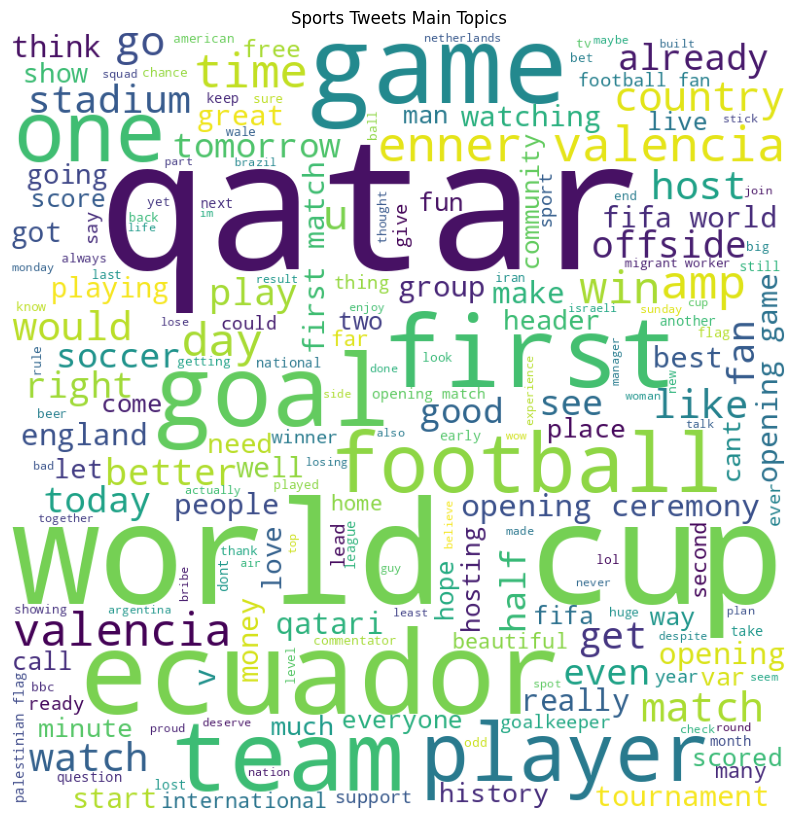

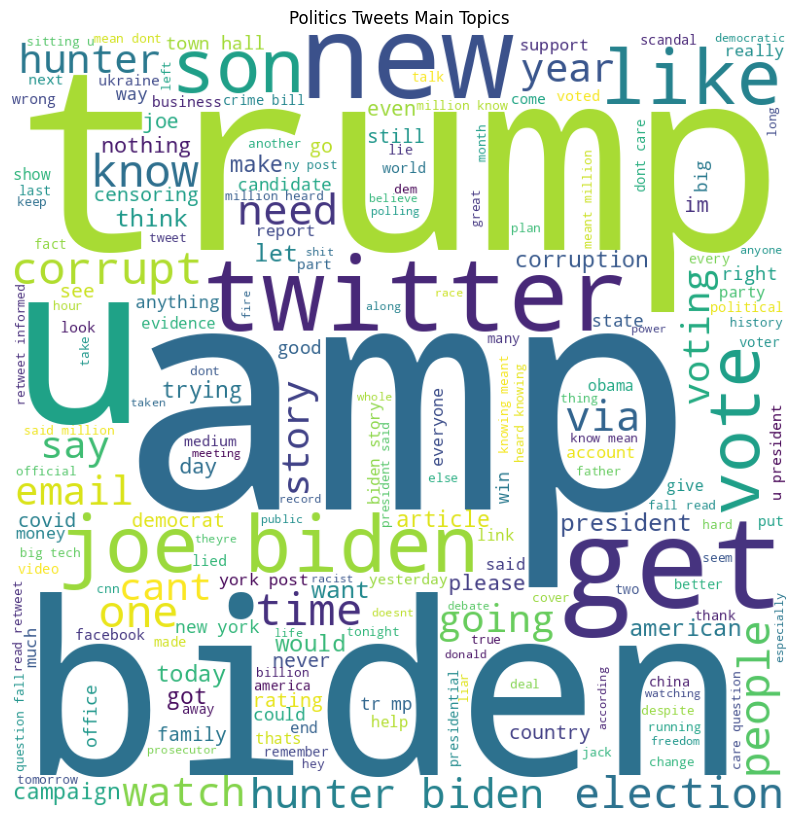

In [84]:
def generate_word_cloud(tweets, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = stop_words, 
                          min_font_size = 10).generate(' '.join(tweets))
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.title(title)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

generate_word_cloud(sports_tweets['lemmatized_tweet'], "Sports Tweets Main Topics")

generate_word_cloud(politics_tweets['lemmatized_tweet'], "Politics Tweets Main Topics")